# Part 3 · Backtesting & Stat Arb Overlay
Construct a daily rebalanced long/short portfolio driven by the alpha scores and evaluate portfolio quality metrics plus a simple pair-trading overlay.

In [1]:
from pathlib import Path
import sys
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

import src.config as config
import src.backtest as backtest
import src.stat_arb as stat_arb

importlib.reload(config)
importlib.reload(backtest)

sns.set_theme(style='whitegrid')
config.ensure_directories()

{'artifacts': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts'),
 'feature_store': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/features'),
 'models': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/models'),
 'plots': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/plots'),
 'reports': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/reports')}

## 1. Load alpha signals and market data
The same clean price panel is required for realized PnL computation; signals come from the previous notebook.

In [2]:
feature_panel = pd.read_parquet(config.FEATURE_STORE_PATH).reset_index()
alphas = pd.read_parquet(config.ALPHA_STORE_PATH).reset_index()
feature_panel[['Date', 'Asset', 'fwd_return_1d']].head()

,Date,Asset,fwd_return_1d
0,2017-01-11,Asset_001,-0.004175
1,2017-01-11,Asset_002,-0.009179
2,2017-01-11,Asset_003,-0.001918
3,2017-01-11,Asset_004,0.018297
4,2017-01-11,Asset_005,-0.016356


## 2. Portfolio construction
Inverse-volatility weighting inside top/bottom quantiles, flat gross leverage, transaction costs.

In [3]:
bt_cfg = backtest.BacktestConfig()
portfolio_results = backtest.run_long_short_backtest(feature_panel, alphas, config=bt_cfg)
portfolio_results['timeline'].head()

,portfolio_ret,gross_ret,benchmark_ret,turnover,cost,equity_curve,benchmark_curve
Date,,,,,,,
2017-01-11,0.001305,0.001305,-0.001830,0.000000,0.000000,1.001305,0.998170
2017-01-12,-0.001369,-0.000687,0.002815,0.681326,0.000681,0.999935,1.000980
2017-01-13,0.004892,0.005472,-0.003744,0.579896,0.000580,1.004827,0.997232
2017-01-16,0.000113,0.000728,-0.001293,0.614382,0.000614,1.004941,0.995943
2017-01-17,0.003041,0.003520,0.003104,0.478799,0.000479,1.007997,0.999034


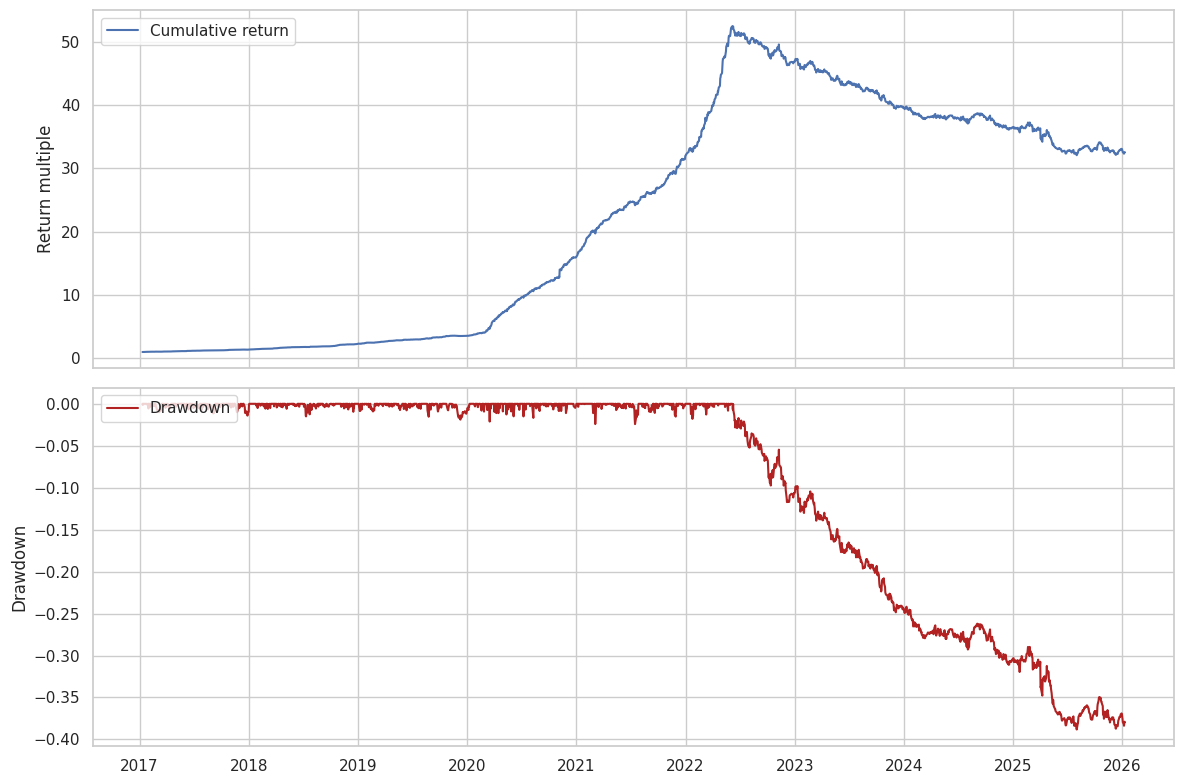

In [4]:
perf = portfolio_results['timeline'].copy()
perf['cum_return'] = (1 + perf['portfolio_ret']).cumprod()
perf['drawdown'] = perf['equity_curve'] / perf['equity_curve'].cummax() - 1
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(perf.index, perf['cum_return'], label='Cumulative return')
ax[0].set_ylabel('Return multiple')
ax[0].legend(loc='upper left')
ax[1].plot(perf.index, perf['drawdown'], color='firebrick', label='Drawdown')
ax[1].set_ylabel('Drawdown')
ax[1].legend(loc='upper left')
plt.tight_layout()

## 3. Turnover and exposure diagnostics

In [5]:
diag = portfolio_results['metrics']
pd.Series(diag)

sharpe              3.772412
max_drawdown       -0.388179
avg_drawdown       -0.095119
total_return       31.554301
relative_return    27.807375
avg_turnover        0.666781
dtype: float64

## 4. Stat-arb pair discovery
Cointegration tests identify stable spreads whose z-score excursions are traded via mean-reversion overlays.

In [6]:
pairs_studies = stat_arb.scan_for_pairs(feature_panel)
pairs = pd.DataFrame([{
    'asset_x': s.asset_a,
    'asset_y': s.asset_b,
    'pvalue': s.pvalue,
    'half_life': s.half_life,
} for s in pairs_studies])
pairs.head()

,asset_x,asset_y,pvalue,half_life
0,Asset_010,Asset_016,0.001635,36.946473
1,Asset_031,Asset_039,0.036195,55.036273


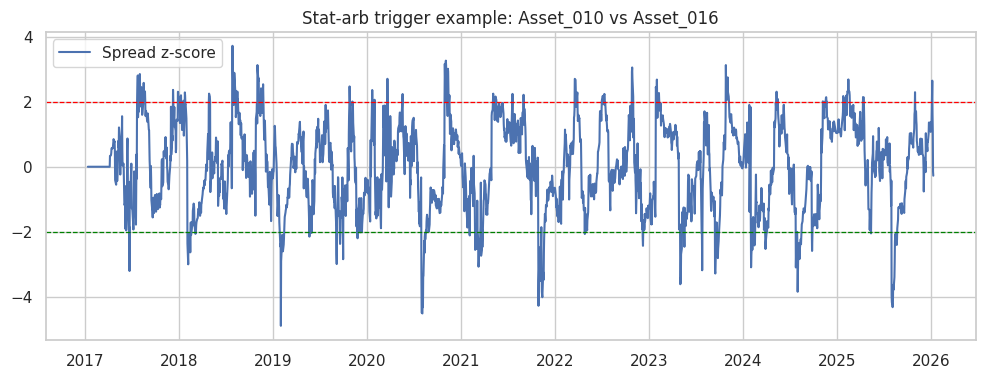

In [7]:
if not pairs.empty:
    example_pair = pairs.iloc[0]
    study = stat_arb.analyze_pair(feature_panel, example_pair['asset_x'], example_pair['asset_y'])
    signal = stat_arb.generate_pair_signal(study)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(signal.index, signal['zscore'], label='Spread z-score')
    ax.axhline(2, color='red', linestyle='--', linewidth=0.9)
    ax.axhline(-2, color='green', linestyle='--', linewidth=0.9)
    ax.set_title(f"Stat-arb trigger example: {example_pair['asset_x']} vs {example_pair['asset_y']}")
    ax.legend(loc='upper left')
else:
    print('No cointegrated pairs found on this sample.')